# Imports

In [44]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Utility Functions

In [59]:
def plot_steps_per_episode(steps_per_episode):
    plt.plot(steps_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Steps per episode')
    plt.axhline(y=100, color='red', linestyle='--')
    for i in range(0, len(steps_per_episode)+1, 10000):
        plt.axvline(x=i, color='grey', linestyle='--')
    plt.show()

def extract_policy(q_table):
    # Take the action with the highest Q-value for each state
    return np.argmax(q_table, axis=1)

def plot_policy(policy, grid_size=(4, 4)):
    # Reshape the policy to match the environment's grid layout
    policy_grid = policy.reshape(grid_size)
    # Create a heatmap
    plt.figure(figsize=(8, 8))
    sns.heatmap(policy_grid, annot=True, cmap="YlGnBu", cbar=False, square=True)
    plt.title('Policy Heatmap (Best Action per State)')
    plt.show()

def check_success_condition(steps_per_episode,consecutive_episodes=5000,threshold=100):
    # Check if the agent was able to achieve X steps for 5000 consecutive episodes
    steps_per_episode = np.array(steps_per_episode)
    for i in range(len(steps_per_episode) - consecutive_episodes):
        if all(steps_per_episode[i:i+consecutive_episodes] >= threshold):
            return True
    return False

def train_agent(env, alpha, gamma, epsilon_decay, num_episodes=6000):
    q_table = np.zeros([env.observation_space.n, env.action_space.n])
    steps_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()[0]
        done = False
        steps = 0
        epsilon = 1.0  # Reset epsilon at the start of each episode

        while not done:
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(q_table[state])  # Exploit

            next_state, reward, done, truncated,_ = env.step(action)
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state
            steps += 1
            epsilon = max(epsilon - epsilon_decay, 0)  # Decaying epsilon

        print(f"Episode {episode} finished after {steps} steps")
        steps_per_episode.append(steps)
        is_success = check_success_condition(steps_per_episode)
    avg_steps = np.mean(steps_per_episode[-100:])  # Average steps of the last 100 episodes
    return avg_steps, q_table, steps_per_episode, is_success

def hyperparameter_search():
    results_dict = {
        'alpha': [],
        'gamma': [],
        'epsilon_decay': [],
        'avg_steps': [],
        'success': []
    }
    env = gym.make('FrozenLake-v1')
    learning_rates = np.linspace(0.1, 1, 10)
    discount_factors = np.linspace(0.1, 1, 10)
    epsilon_decays = np.linspace(0.000001, 0.001, 10)
    best_params = {}
    min_steps = float('inf')

    for alpha in learning_rates:
        for gamma in discount_factors:
            for decay in epsilon_decays:
                avg_steps, q_table ,steps_per_episode,is_success = train_agent(env, alpha, gamma, decay)
                print(f"Alpha: {alpha}, Gamma: {gamma}, Decay: {decay}, Avg Steps: {avg_steps} Success: {is_success}")

                results_dict['alpha'].append(alpha)
                results_dict['gamma'].append(gamma)
                results_dict['epsilon_decay'].append(decay)
                results_dict['avg_steps'].append(avg_steps)
                results_dict['success'].append(is_success)

                if avg_steps < min_steps:
                    min_steps = avg_steps
                    best_params = {'alpha': alpha, 'gamma': gamma, 'epsilon_decay': decay}

    return best_params, min_steps , pd.DataFrame(results_dict)

In [60]:
best_hyperparameters, best_performance, results_df = hyperparameter_search()
print("Best Hyperparameters:", best_hyperparameters)
print("Best Average Steps to Goal:", best_performance)

Episode 0 finished after 4 steps
Episode 1 finished after 6 steps
Episode 2 finished after 12 steps
Episode 3 finished after 3 steps
Episode 4 finished after 3 steps
Episode 5 finished after 9 steps
Episode 6 finished after 6 steps
Episode 7 finished after 10 steps
Episode 8 finished after 10 steps
Episode 9 finished after 3 steps
Episode 10 finished after 7 steps
Episode 11 finished after 8 steps
Episode 12 finished after 9 steps
Episode 13 finished after 18 steps
Episode 14 finished after 14 steps
Episode 15 finished after 2 steps
Episode 16 finished after 7 steps
Episode 17 finished after 7 steps
Episode 18 finished after 4 steps
Episode 19 finished after 10 steps
Episode 20 finished after 6 steps
Episode 21 finished after 2 steps
Episode 22 finished after 4 steps
Episode 23 finished after 3 steps
Episode 24 finished after 4 steps
Episode 25 finished after 7 steps
Episode 26 finished after 3 steps
Episode 27 finished after 6 steps
Episode 28 finished after 8 steps
Episode 29 finishe

KeyboardInterrupt: 

In [41]:
results_df.style.background_gradient(cmap='Blues')

,alpha,gamma,epsilon_decay,avg_steps,success
0,0.500000,0.800000,0.001000,6.760000,None
1,0.500000,0.800000,0.005000,7.040000,None
2,0.500000,0.800000,0.010000,7.940000,None
3,0.500000,0.900000,0.001000,7.010000,None
4,0.500000,0.900000,0.005000,8.130000,None
5,0.500000,0.900000,0.010000,7.560000,None
6,0.500000,0.990000,0.001000,8.400000,None
7,0.500000,0.990000,0.005000,8.530000,None
8,0.500000,0.990000,0.010000,8.350000,None
9,0.800000,0.800000,0.001000,7.050000,None


In [132]:

# Initialize the FrozenLake environment
env = gym.make('FrozenLake-v1',is_slippery=True)

# Initialize Q-table with zeros for each state-action pair
q_table = np.zeros([env.observation_space.n, env.action_space.n])

# Hyperparameters
alpha = 0.8   # Learning rate
gamma = 0.3  # Discount factor
epsilon = 1.0   # Epsilon-greedy probability
num_episodes = 10000
# Decay rate as a function of number of episodes
decay_rate = 0.0002  # Decay rate for epsilon
batch_e_greedy = True
batch_size = 500
decay_rate = 0.1
# For stats
steps_per_episode = []
# Q-learning algorithm
for episode in range(num_episodes):
    state = env.reset()[0]
    done = False
    steps = 0
    while not done:

        # Epsilon-greedy action selection
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore action space
        else:
            action = np.argmax(q_table[state])  # Exploit learned values
        steps +=1
        #Take action A and Observe R and S'
        next_state, reward, done, truncated,info = env.step(action)
        # Q-table update
        # Old value is Q(S,A)
        old_value = q_table[state, action]
        # Now that we are at state S' we can look at all possible actions and pick the best one
        next_max = np.max(q_table[next_state])
        # Updating Q(S,A) with the new value
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value
        
        state = next_state
    if episode % 500 == 0:
        print(f"epsilon at episode {episode}: {epsilon}")
    # print(f"Episode {episode} finished after {steps} steps")
    # Decaying epsilon
    steps_per_episode.append(steps)
    if batch_e_greedy:
        if episode % batch_size == 0:
            epsilon = epsilon - decay_rate if epsilon > 0 else 0
    else:
        epsilon = epsilon - decay_rate if epsilon > 0 else 0

print("Training finished.")



epsilon at episode 0: 1.0
epsilon at episode 500: 0.9
epsilon at episode 1000: 0.8
epsilon at episode 1500: 0.7000000000000001
epsilon at episode 2000: 0.6000000000000001
epsilon at episode 2500: 0.5000000000000001
epsilon at episode 3000: 0.40000000000000013
epsilon at episode 3500: 0.30000000000000016
epsilon at episode 4000: 0.20000000000000015
epsilon at episode 4500: 0.10000000000000014
epsilon at episode 5000: 1.3877787807814457e-16
epsilon at episode 5500: -0.09999999999999987
epsilon at episode 6000: 0
epsilon at episode 6500: 0
epsilon at episode 7000: 0
epsilon at episode 7500: 0
epsilon at episode 8000: 0
epsilon at episode 8500: 0
epsilon at episode 9000: 0
epsilon at episode 9500: 0
Training finished.


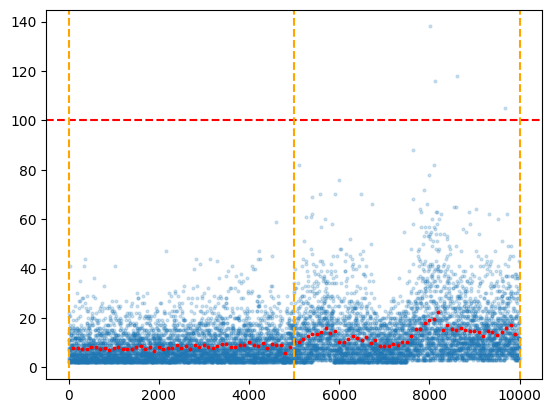

In [133]:
steps_per_episode = np.array(steps_per_episode)
plt.scatter(y=steps_per_episode,x=np.arange(len(steps_per_episode)),s=4,alpha=0.2)
plt.axhline(y=100, color='red', linestyle='--')
for i in range(0, len(steps_per_episode)+1, 5000):
    plt.axvline(x=i, color='orange', linestyle='--')
# Moving average
window = 100
step = 100
rolling_mean = pd.Series(steps_per_episode).rolling(window,step=step).mean()
plt.scatter(y=rolling_mean,x=np.arange(len(steps_per_episode),step=step),s=3,color='red')

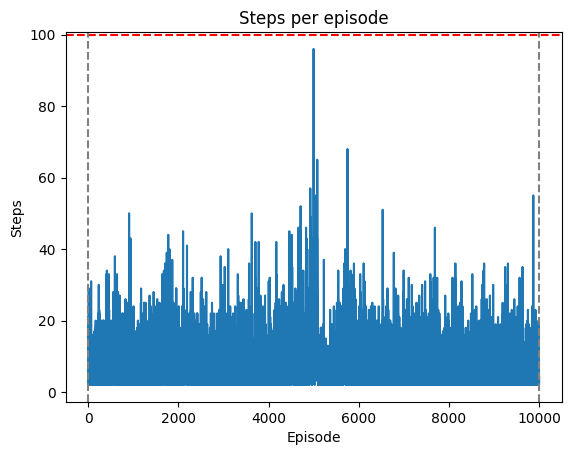

In [131]:
plot_steps_per_episode(steps_per_episode)

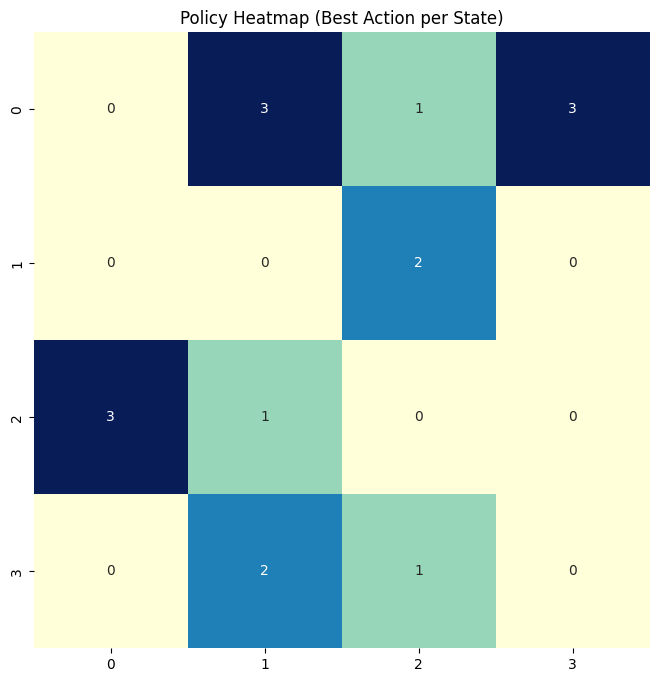

In [16]:


# Assuming q_table is your trained Q-table
policy = extract_policy(q_table)
plot_policy(policy)
